In [ ]:
pip install python_speech_features

In [4]:
import numpy as np
from tensorflow import keras
import soundfile
import json

import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
from keras.utils.vis_utils import plot_model


import _pickle as pickle
from numpy.lib.stride_tricks import as_strided

from keras.layers import (Input, Lambda)
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
!ls /content/drive/"My Drive"

 ALFFA_PUBLIC				   personaldocs
 AMHARIC				  'powerpoint 1'
 Classroom				  'Project data'
'Colab Notebooks'			  'Stella Makena Mutacho -Task.pdf'
'Contact Information (File responses)'	  'Strategy Management task.docx'
'Contact Information (Responses).gsheet'   SWAHILI
'Copy of WEEK 4 CAREER EXERCISE.gdoc'	   train_data.csv
 CV.docx				  'week 1 career task.gdoc'
'Navigating Remote Workspaces.gslides'


In [8]:
import os
os.chdir("/content/drive/My Drive/AMHARIC")
os.listdir()

['README.md',
 'data',
 'kaldi-script',
 'lang',
 'lm',
 'train_data.csv',
 'valid_corpus.json',
 'models',
 'train_corpus.json',
 'model_1.png']

In [9]:
os.listdir()

['README.md',
 'data',
 'kaldi-script',
 'lang',
 'lm',
 'train_data.csv',
 'valid_corpus.json',
 'models',
 'train_corpus.json',
 'model_1.png']

1. Sampling the first audio file at the default sampling rate

In [ ]:
train_audio_path = '/content/drive/My Drive/AMHARIC/data/train/wav/'
samples, sample_rate = librosa.load(train_audio_path+'tr_1_tr01001.wav')
print(samples)
print(sample_rate)

[-0.00502738 -0.00577551 -0.0046026  ... -0.00579655 -0.00516981
  0.        ]
22050


2. Sampling at *44100HZ* instead of the default sampling rate of 22050hz

In [ ]:
from IPython import display  as ipd

In [ ]:
audio, rate=librosa.load(train_audio_path+'tr_1_tr01001.wav', sr=44100)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
import matplotlib.pyplot as plt


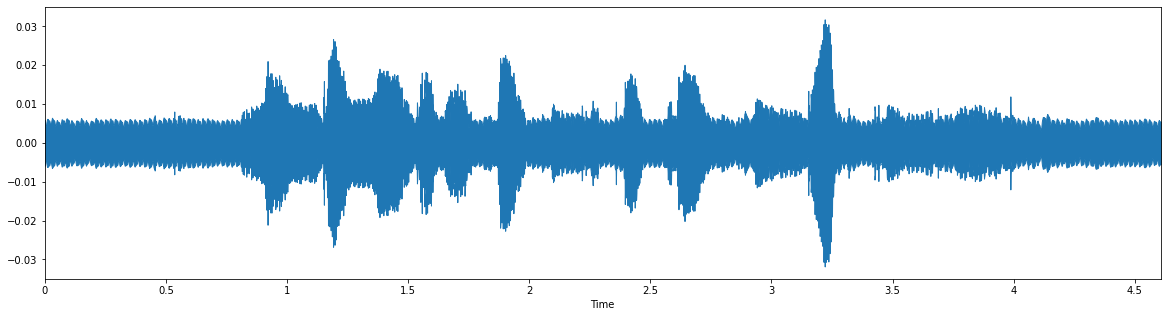

In [ ]:
%matplotlib inline
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(audio, sr=rate)

Function to generate parameters for the spectogram

In [ ]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [ ]:
x,freqs= spectrogram(audio)
freqs

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

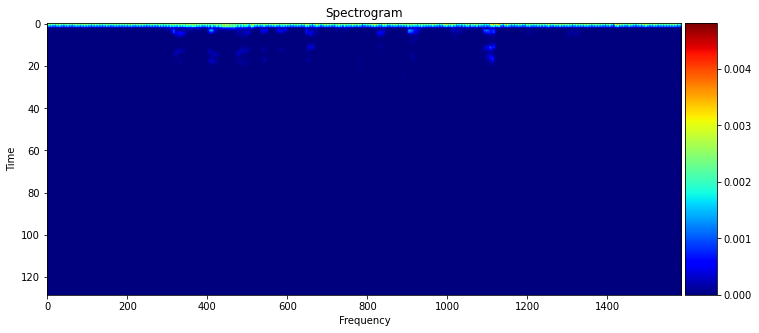

In [ ]:
plot_spectrogram_feature(x)

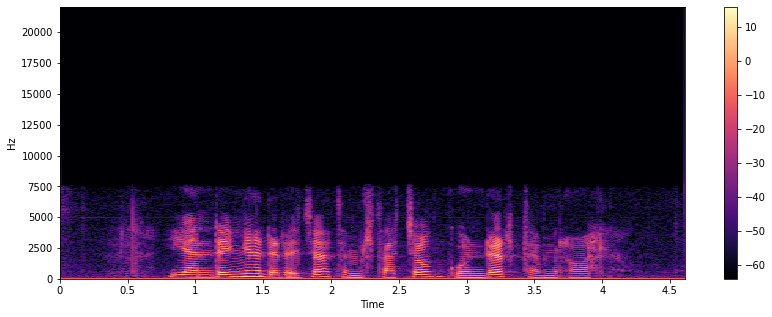

In [ ]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data.csv


### Acoustic Modelling

1. Convert abstracts from list of strings into list of lists of integers (sequences)
2. Create feature and labels from sequences
3. Build LSTM model with Embedding, LSTM, and Dense layers
4. Load in pre-trained embeddings
5. Train model to predict next work in sequence
6. Make predictions by passing in starting sequence

Load The transcriptions

In [10]:
def tran_loader(filename):
  name_to_text = {}
  with open (filename, encoding="utf-8")as f:
    f.readline()
    for line in f:
      name=line.split("</s>")[1]
      name=name.replace('(', '')
      name=name.replace(')', '')
      name=name.replace('\n','')
      name=name.replace(' ','')
      text=line.split("</s>")[0]
      text=text.replace("<s>","")
      name_to_text[name]=text
    return name_to_text

### Getting the label and transciption matching it

In [11]:
amharic_train_labels = tran_loader("/content/drive/My Drive/AMHARIC/data/train/trsTrain.txt")

In [12]:
amharic_train_labels

{'tr_2_tr01002': ' የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖርት ና መጓጓዣ ገንዘብ ተሰጥቷ ቸው መሸኘታቸው ን አመልክቶ በ የ ዞ ናቸው እንደ ደረሱ መቃቋሚያ እንደሚ ሰጣቸው ም አስ ታውቋል ',
 'tr_3_tr01003': ' በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ የ ተገናኙ ት መድን ና ሙገር ሲሚንቶ ሲ ሆኑ በ ውጤቱ ም ሶስት ለ ሶስት ተለያይ ተዋል ',
 'tr_4_tr01004': ' ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው ',
 'tr_5_tr01005': ' ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች ',
 'tr_6_tr01006': ' ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያል ተረገጠ ች አገር ኢትዮጵያ ና ት ',
 'tr_7_tr01007': ' እህቶቹ የኤርትራ ዜጐች ና የ ሻእቢያ ደጋፊዎች ናቸው ',
 'tr_8_tr01008': ' እናንተ ም መቀበሪያ እንዳ ታጡ ተጠንቀቁ ',
 'tr_9_tr01009': ' አንቶኔሊ በ አጼ ምንሊክ ፊት የ ፈጸመው ድፍረት በ ኢጣሊያ ን ምክር ቤት አስተ ቸው ',
 'tr_10_tr01010': ' ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎማሲ ያቸው እስራኤል ንም ያስ ወር ፋቸው ጀመር ',
 'tr_11_tr01011': ' ከ የ አቅጣጫ ው እየ ደረሷቸው ያሉ መረጃዎች አሳሳቢ ችግሮች እየ ደረሱ መሆናቸው ን የሚ ጠቁሙ መሆናቸው ን ፕሬዝዳንቱ ተናግረ ዋል ',
 'tr_12_tr01012': ' ከ ማወቁ በፊት እንደ ተበጠበጠ ገበያ እንዳይ በታተን ይህ ነው አጀንዳ ችን ሌላ አጀንዳ የ ለ ንም ',
 'tr_13_tr01013': ' ኢትዮጵያ ም ሰራዊቷ በ ኤርትራ እንደሚ 

##Generating the meta data

In [16]:
def meta_data(trans, path ):
  target=[]
  features=[]
  filenames=[]
  duration_of_recordings=[]
  for k in trans:
    filename=path+k +".wav"
    filenames.append(filename)
    audio, fs = librosa.load(filename, sr=None)
    duration_of_recordings.append(float(len(audio)/fs))
   
    lable = trans[k]
    target.append(lable)
  return filenames, target,duration_of_recordings

In [2]:
filenames, target,duration_of_recordings= meta_data(amharic_train_labels,'/content/drive/My Drive/AMHARIC/data/train/wav/')

NameError: ignored

#### Generating a dataframe with the path to the audio files, text transcription and duration of each recording

In [ ]:
import pandas as pd 
data=pd.DataFrame({'key': filenames,'text': target, 'duration':duration_of_recordings})

In [ ]:
data.head()

,key,text,duration
0,/content/drive/My Drive/AMHARIC/data/train/wav...,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስ...,16.384
1,/content/drive/My Drive/AMHARIC/data/train/wav...,በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ...,14.592
2,/content/drive/My Drive/AMHARIC/data/train/wav...,ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው,4.736
3,/content/drive/My Drive/AMHARIC/data/train/wav...,ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳ...,8.192
4,/content/drive/My Drive/AMHARIC/data/train/wav...,ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያ...,8.704


#### saving the dataframe to a json file for train and valid corpus 

In [ ]:
# Extracting contents of the dataframe into a dictionary
import json
md_json = data.to_dict(orient='records')
with open("train_corpus.json", 'w') as f:
  json.dump(md_json, f, indent=2, ensure_ascii=False)


In [ ]:
!ls 

data  kaldi-script  lang  lm  README.md  train_corpus.json  train_data.csv


In [ ]:
import sklearn.model_selection

In [ ]:
x = data.drop(columns=['text'])

In [ ]:
y = data.text

train_corpus_x, val_corpus_x, train_corpus_y, val_corpus_y = sklearn.model_selection.train_test_split(x, y, test_size=0.2)

In [ ]:
train_corpus_df = pd.concat([train_corpus_x, train_corpus_y], axis=1)
val_corpus_df = pd.concat([val_corpus_x, val_corpus_y], axis=1)

In [ ]:
import json
train_json = train_corpus_df.to_dict(orient='records')
with open("train_corpus.json", 'w') as f:
  json.dump(train_json, f, indent=2, ensure_ascii=False)

In [ ]:
import json
val_json = val_corpus_df.to_dict(orient='records')
with open("valid_corpus.json", 'w') as f:
  json.dump(val_json, f, indent=2, ensure_ascii=False)

#### Providing the supported ccharacters in the Amharic language

In [13]:
supported = """
ሀ ሁ ሂ ሄ ህ ሆ
ለ ሉ ሊ ላ ሌ ል ሎ ሏ
መ ሙ ሚ ማ ሜ ም ሞ ሟ
ረ ሩ ሪ ራ ሬ ር ሮ ሯ
ሰ ሱ ሲ ሳ ሴ ስ ሶ ሷ
ሸ ሹ ሺ ሻ ሼ ሽ ሾ ሿ
ቀ ቁ ቂ ቃ ቄ ቅ ቆ ቋ
በ ቡ ቢ ባ ቤ ብ ቦ ቧ
ቨ ቩ ቪ ቫ ቬ ቭ ቮ ቯ
ተ ቱ ቲ ታ ቴ ት ቶ ቷ
ቸ ቹ ቺ ቻ ቼ ች ቾ ቿ
ኋ
ነ ኑ ኒ ና ኔ ን ኖ ኗ
ኘ ኙ ኚ ኛ ኜ ኝ ኞ ኟ
አ ኡ ኢ ኤ እ ኦ
ኧ
ከ ኩ ኪ ካ ኬ ክ ኮ
ኳ
ጾ
ጻ
ኸ
ኲ
ጽ
ጸ
ጹ
ጺ
ጼ
ኰ
ጿ
ወ ዉ ዊ ዋ ዌ ው ዎ
ዘ ዙ ዚ ዛ ዜ ዝ ዞ ዟ
ዠ ዡ ዢ ዣ ዤ ዥ ዦ ዧ
የ ዩ ዪ ያ ዬ ይ ዮ
ደ ዱ ዲ ዳ ዴ ድ ዶ ዷ
ጀ ጁ ጂ ጃ ጄ ጅ ጆ ጇ
ገ ጉ ጊ ጋ ጌ ግ ጐ ጓ ጔ
ጠ ጡ ጢ ጣ ጤ ጥ ጦ ጧ
ጨ ጩ ጪ ጫ ጬ ጭ ጮ ጯ
ጰ ጱ ጲ ጳ ጴ ጵ ጶ ጷ
ፀ ፁ ፂ ፃ ፄ ፅ ፆ ፇ
ፈ ፉ ፊ ፋ ፌ ፍ ፎ ፏ
ፐ ፑ ፒ ፓ ፔ ፕ ፖ
""".split()

char_map = {}
char_map[""] = 0
char_map["<SPACE>"] = 1
index = 2
for c in supported:
    char_map[c] = index
    index += 1
index_map = {v+1: k for k, v in char_map.items()}

#### Generate input data

In [14]:

RNG_SEED = 123

def make_audio_gen(train_json,
                   valid_json,
                   minibatch_size=20,
                   spectrogram=True,
                   mfcc_dim=13,
                   sort_by_duration=False,
                   max_duration=10.0):
    return AudioGenerator(train_json, valid_json, minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)


In [15]:
"""
Defines a class that is used to featurize audio clips, and provide
them to the network for training or testing.
"""
class AudioGenerator():
    def __init__(self, train_corpus, valid_corpus, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """
        self.train_corpus = train_corpus
        self.valid_corpus = valid_corpus
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
            self.train_length = len(self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
            self.valid_length = len(self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self):
        desc_file=self.train_corpus
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self):
        desc_file=self.valid_corpus
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self):
        desc_file='test_corpus.json'
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        with open(desc_file, encoding='utf-8') as f:
            json_line_files = json.load(f)
            print(len(json_line_files))
        try:
            for line_num, json_line in enumerate(json_line_files):
                try:
                    spec = json_line
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    # Change to (KeyError, ValueError) or
                    # (KeyError,json.decoder.JSONDecodeError), depending on
                    # json module version
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        except:
            print("Error loading")

        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)

    def train_length(self):
        return len(self.train_texts)
    
    def valid_length(self):
        return len(self.valid_texts)


def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    """ Visualizing the data point in the training set at the supplied index
    """
    # obtain spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain text label
    vis_text = audio_gen.train_texts[index]
    # obtain raw audio
    vis_raw_audio, _ = librosa.load(amharic_path(vis_audio_path))
    # print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio, title='Audio Signal', size=(12, 3)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

#### Defining the model

In [16]:
def model_1(input_dim, units, activation, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # TODO: Add batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    plot_model(model, to_file='model_1.png')
    return model

### Training

In [17]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [18]:
def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model


In [19]:
def train(audio_gen,
          input_to_softmax, 
          model_name,
          minibatch_size=20,
          optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          epochs=20,
          verbose=1):    
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)

    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    # make results/ directory, if necessary
    if not os.path.exists('models'):
        os.makedirs('models')

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='models/'+model_name+'.h5', verbose=0)

    # train the model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose, use_multiprocessing=True)

    # save model loss
    with open('models/'+model_name+'.pickle', 'wb') as f:
        pickle.dump(hist.history, f)

### Training the RNN network

In [20]:
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

In [21]:
TRAIN_CORPUS = "train_corpus.json"
VALID_CORPUS = "valid_corpus.json"

MFCC_DIM = 13
SPECTOGRAM = False
EPOCHS = 5
MODEL_NAME = "RNN_model"

################ Reminder MINI_BATCH_SIZE=250 
MINI_BATCH_SIZE = 250

SORT_BY_DURATION=False
MAX_DURATION = 10.0

audio_gen = make_audio_gen(TRAIN_CORPUS, VALID_CORPUS, spectrogram=False, mfcc_dim=MFCC_DIM,
                           minibatch_size=MINI_BATCH_SIZE, sort_by_duration=SORT_BY_DURATION,
                           max_duration=MAX_DURATION)
# add the training data to the generator
audio_gen.load_train_data()
audio_gen.load_validation_data()

10874
2175


In [22]:
model = model_1(input_dim=13,
                units=5,
                activation='relu',
                output_dim=len(char_map)+1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 13)]        0         
                                                                 
 rnn (GRU)                   (None, None, 5)           300       
                                                                 
 batch_normalization (BatchN  (None, None, 5)          20        
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, None, 234)        1404      
 ibuted)                                                         
                                                                 
 softmax (Activation)        (None, None, 234)         0         
                                                                 
Total params: 1,724
Trainable params: 1,714
Non-trainable par

Training the model

In [23]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [24]:
def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model


In [26]:
def train(audio_gen,
          input_to_softmax, 
          model_name,
          minibatch_size=20,
          optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          epochs=20,
          verbose=1):    
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)

    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    # make results/ directory, if necessary
    if not os.path.exists('models'):
        os.makedirs('models')

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='models/'+model_name+'.h5', verbose=0)

    # train the model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose, use_multiprocessing=True)

    # save model loss
    with open('models/'+model_name+'.pickle', 'wb') as f:
        pickle.dump(hist.history, f)

In [27]:
def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            # print("checking character " + c + " in map:")
            # print(char_map)
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

In [28]:
train(audio_gen, input_to_softmax=model, model_name=MODEL_NAME, epochs=EPOCHS, minibatch_size=MINI_BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
37/37 [==============================] - 2204s 61s/step - loss: 508.5477 - val_loss: 204.0946
Epoch 2/5
37/37 [==============================] - 394s 11s/step - loss: 191.1458 - val_loss: 197.9733
Epoch 3/5
37/37 [==============================] - 390s 10s/step - loss: 185.9834 - val_loss: 189.7205
Epoch 4/5
37/37 [==============================] - 390s 10s/step - loss: 185.1977 - val_loss: 193.5183
Epoch 5/5
37/37 [==============================] - 381s 10s/step - loss: 184.7039 - val_loss: 203.1241


### Prediction

In [39]:
def predict(data_gen, index, partition, model, verbose=True):
    """ Print a model's decoded predictions
    Params:
        data_gen: Data to run prediction on
        index (int): Example to visualize
        partition (str): Either 'train' or 'validation'
        model (Model): The acoustic model
    """
    audio_path,data_point,transcr,prediction = predict_raw(data_gen, index, partition, model)
    output_length = [model.output_length(data_point.shape[0])]
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length, greedy=False)[0][0])+1).flatten().tolist()
    predicted = ''.join(int_sequence_to_text(pred_ints)).replace("<SPACE>", " ")
    wer_val = wer(transcr, predicted)
    if verbose:
        display(Audio(audio_path, embed=True))
        print('Truth: ' + transcr)
        print('Predicted: ' + predicted)
        print("wer: %d" % wer_val)
    return wer_val

In [29]:
def predict_raw(data_gen, index, partition, model):
    """ Get a model's decoded predictions
    Params:
        data_gen: Data to run prediction on
        index (int): Example to visualize
        partition (str): Either 'train' or 'validation'
        model (Model): The acoustic model
    """

    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    prediction = model.predict(np.expand_dims(data_point, axis=0))
    return (audio_path,data_point,transcr,prediction)



In [41]:
def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

In [44]:
# Code adapted from https://martin-thoma.com/word-error-rate-calculation/
def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.

    Parameters
    ----------
    r : list
    h : list

    Returns
    -------
    int

    Examples
    --------
    >>> wer("who is there".split(), "is there".split())
    1
    >>> wer("who is there".split(), "".split())
    3
    >>> wer("".split(), "who is there".split())
    3
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

In [43]:
def calculate_wer(model, model_name, data_gen, partition, length):
    start = time.time()
    def wer_single(i):
        wer = predict(data_gen, i, partition, model, verbose=False)
        if (i%100==0) and i>0:
            print("processed %d in %d minutes" % (i, ((time.time() - start)/60)))
        return wer
    wer = list(map(lambda i: wer_single(i), range(1, length)))
    print("Total time: %f minutes" % ((time.time() - start)/60))
    filename = 'models/' + model_name + '_' + partition + '_wer.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(wer, handle)
    return wer




In [31]:
def load_wer(model_name, partition):
    filename = 'models/' + model_name + '_' + partition + '_wer.pickle'
    return pickle.load(open(filename, "rb"))

In [49]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


In [47]:
def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

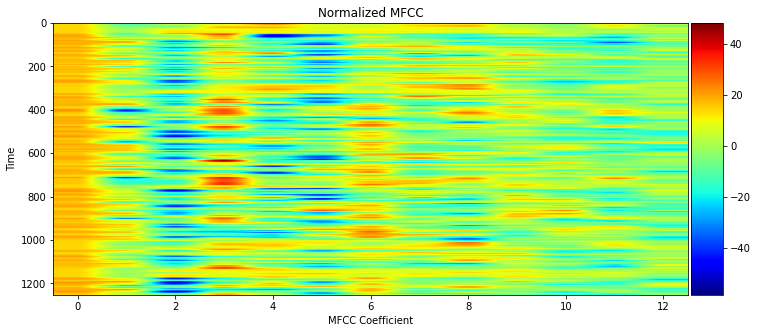

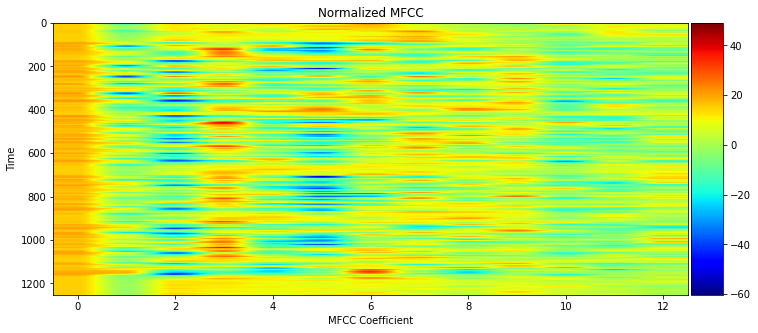

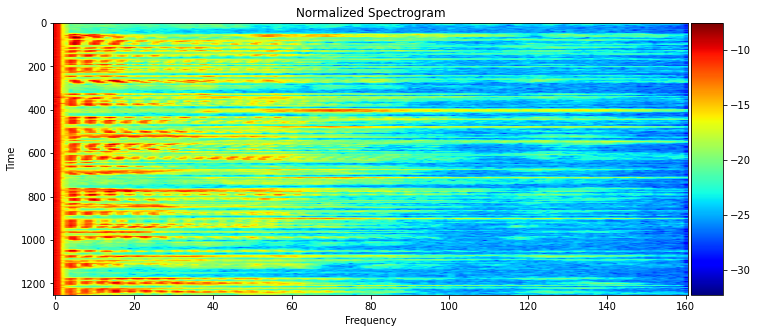

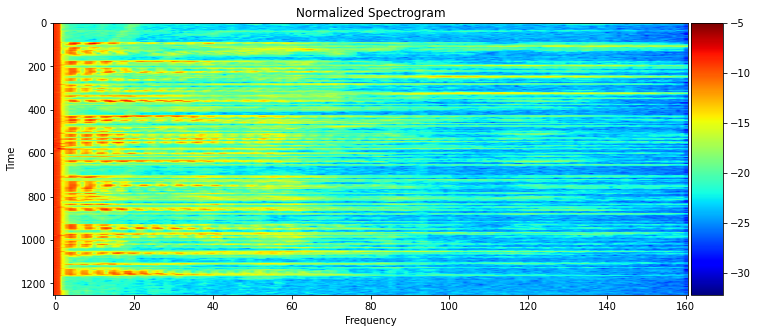

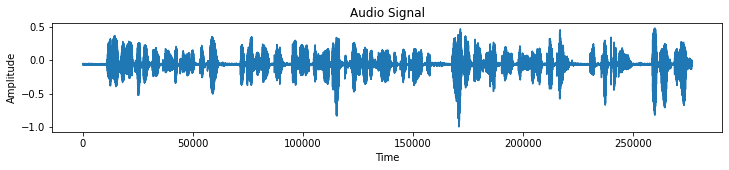

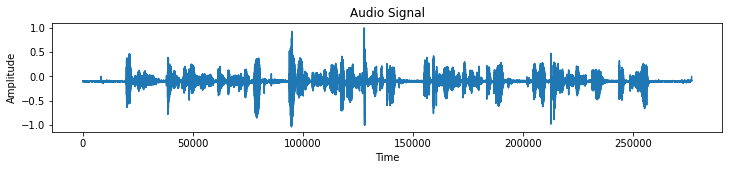

In [50]:
def plot_raw(name):
    raw_audio = librosa.load("/content/drive/My Drive/AMHARIC/data/test/wav/" + name)[0]
    plot_raw_audio(raw_audio, size=(12,2))

def plot_spect(name):
    plot_spectrogram_feature(spectrogram_from_file("/content/drive/My Drive/AMHARIC/data/test/wav/" + name))

def plot_mfcc(name):
    (rate, sig) = wav.read("/content/drive/My Drive/AMHARIC/data/test/wav/" + name)
    plot_mfcc_feature(mfcc(sig, rate, numcep=13))

plot_mfcc("01_d501021.wav")
plot_mfcc("01_d501022.wav")


plot_spect("01_d501021.wav")
plot_spect("01_d501022.wav")


plot_raw("01_d501021.wav")
plot_raw("01_d501022.wav")


In [35]:
model = model_1(input_dim=13,
                units=5,
                activation='relu',
                output_dim=len(char_map)+1)
model.load_weights('models/RNN_model.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 13)]        0         
                                                                 
 rnn (GRU)                   (None, None, 5)           300       
                                                                 
 batch_normalization_1 (Batc  (None, None, 5)          20        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, None, 234)        1404      
 tributed)                                                       
                                                                 
 softmax (Activation)        (None, None, 234)         0         
                                                                 
Total params: 1,724
Trainable params: 1,714
Non-trainable p

In [36]:
index_map[0]=''

In [37]:
from IPython.display import Audio
from IPython.display import Markdown, display

In [45]:
predict(audio_gen,14, 'train', model)
_,_,_,raw_pred = predict_raw(audio_gen,14, 'train', model)
raw_pred_char = np.vstack([sorted(char_map.keys(), key=lambda k: char_map[k]) + ['BLANK'], raw_pred[0]])

Truth:  ሁለት መቶ ሺ ያህሉ ደግሞ አብዛኛዎቹ ሲ ሰደዱ ቀሪዎቹ ሞ ተዋል ወይን ም ተ ሸሽገ ዋል 
Predicted:  ን ኢ 
wer: 53
